Versione 2 --> LSTM multiclasse con train_test_split + scelta timesteps + feature selezionate con RFE (44) + TIMESTAMP ORDINATO.

# LOAD THE DATA

In [140]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

Creo un DataFrame pandas dal dataset CSE IDS-2018:

In [141]:
import pandas as pd

# Apro il file CSV e creo un DataFrame
df = pd.read_csv('Friday-16-02-2018_TrafficForML_CICFlowMeter.csv', low_memory=False)      # for mixed types

# HANDLE TARGET FEATURE

In [142]:
# Analizzo la colonna dei target
df["Label"].unique()

array(['Benign', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'Label'],
      dtype=object)

In [143]:
# Osservo il numero di occorrenze per ogni tipo di attacco
df["Label"].value_counts()

Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Label                            1
Name: count, dtype: int64

Nei target è presente un'istanza con valore "Label" (non definito), la droppo:

In [144]:
# Scarto le istanze 'Label' della feature Label
df.drop(df.loc[df["Label"] == "Label"].index, inplace=True)

# Verifico
df["Label"].value_counts()

Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: count, dtype: int64

In [145]:
# Per comodità rinomino la colonna dei target
labels = df['Label']

## LABEL ENCODER (Cross validation)

Mi serve di effettuare un encoding sull'intero dataset, che userò successivamente per la cross validation.

In [146]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

Uso LabelEncoder per trasformare le etichette di classe in numeri interi:

In [147]:
encoder_cross = LabelEncoder()

# Addestro l'encoder sulle categorie di attacchi (impara ad associare ogni categoria ad un numero univoco)
encoder_cross.fit(labels)

# Trasformo le labels in una sequenza di numeri interi
y_dataset_encoded = encoder_cross.transform(labels)

# Verifico che le classi siano corrette
encoder_cross.classes_

array(['Benign', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest'],
      dtype=object)

In [148]:
# Converto i numeri interi in vettori one-hot
y_dataset_categorical = to_categorical(y_dataset_encoded, num_classes=len(encoder_cross.classes_))

# TIMESTAMP FEATURE - Understanding timesteps

In [149]:
df['Timestamp'].head(50)

0     16/02/2018 08:27:23
1     16/02/2018 08:30:12
2     16/02/2018 08:26:55
3     16/02/2018 08:33:01
4     16/02/2018 08:27:59
5     16/02/2018 08:35:50
6     16/02/2018 08:38:39
7     16/02/2018 08:41:28
8     16/02/2018 08:44:17
9     16/02/2018 08:47:06
10    16/02/2018 08:38:02
11    16/02/2018 08:49:55
12    16/02/2018 08:51:18
13    16/02/2018 08:52:44
14    16/02/2018 08:56:00
15    16/02/2018 08:56:00
16    16/02/2018 08:56:01
17    16/02/2018 08:56:01
18    16/02/2018 08:56:00
19    16/02/2018 08:56:00
20    16/02/2018 08:55:32
21    16/02/2018 08:58:21
22    16/02/2018 09:01:10
23    16/02/2018 08:42:10
24    16/02/2018 09:03:59
25    16/02/2018 08:55:24
26    16/02/2018 09:09:27
27    16/02/2018 09:09:27
28    16/02/2018 09:06:48
29    16/02/2018 09:09:37
30    16/02/2018 09:12:26
31    16/02/2018 08:34:20
32    16/02/2018 09:15:15
33    16/02/2018 09:18:04
34    16/02/2018 09:22:07
35    16/02/2018 09:20:53
36    16/02/2018 09:23:42
37    16/02/2018 09:26:31
38    16/02/

In [150]:
# Converto la colonna Timestamp in datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Ordino il dataframe per la colonna Timestamp in ordine cronologico
df = df.sort_values(by='Timestamp')

# Verifico
df["Timestamp"].head(50)

91659    2018-02-16 01:00:32
91658    2018-02-16 01:01:42
91661    2018-02-16 01:03:21
91689    2018-02-16 01:03:50
91663    2018-02-16 01:06:10
91662    2018-02-16 01:08:55
91664    2018-02-16 01:08:59
91665    2018-02-16 01:11:48
91670    2018-02-16 01:14:37
91666    2018-02-16 01:14:53
91667    2018-02-16 01:15:11
91668    2018-02-16 01:17:04
91669    2018-02-16 01:17:14
91672    2018-02-16 01:17:26
209903   2018-02-16 01:18:03
91673    2018-02-16 01:20:15
91682    2018-02-16 01:23:04
91674    2018-02-16 01:23:54
91676    2018-02-16 01:24:01
91675    2018-02-16 01:24:13
91678    2018-02-16 01:24:16
91677    2018-02-16 01:24:20
91680    2018-02-16 01:24:27
91679    2018-02-16 01:24:34
91681    2018-02-16 01:24:45
91685    2018-02-16 01:25:53
91683    2018-02-16 01:26:21
91684    2018-02-16 01:26:24
91687    2018-02-16 01:28:42
91686    2018-02-16 01:29:44
91688    2018-02-16 01:31:03
91690    2018-02-16 01:31:31
91691    2018-02-16 01:34:20
91694    2018-02-16 01:37:09
91692    2018-

Osservo la colonna Timestamp per capire ogni quanto sono state fatte le osservazioni sul traffico di rete:

In [151]:
# Converto la colonna Timestamp in datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Trovo il timestamp minimo e massimo
min_timestamp = df['Timestamp'].min()
max_timestamp = df['Timestamp'].max()

# Calcolo la durata totale
duration = max_timestamp - min_timestamp

print(f"Il periodo totale di osservazione è: {duration}")

Il periodo totale di osservazione è: 0 days 11:57:52


# CREATE TEST SET AND VAL SET

Suddivido il DataFrame in training set (60%), test set (20%) e validation set(20%).

In [152]:
from sklearn.model_selection import train_test_split

# Prima suddivisione: divido il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

# Seconda suddivisione: divido il training set rimanente in training set e validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Verifico la shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(629144, 80) (629144,)
(209715, 80) (209715,)
(209715, 80) (209715,)


## LABEL ENCODER (Train_test_split)

Definisco un'istanza separata del LabelEncoder per il df che verrà valutato sulla suddivisione _train test split_. Questo è necessario perchè in questo caso devo applicare il _fit_ solo al set di addestramento, e non all'intero df.

In [153]:
tts_encoder = LabelEncoder()

# Codifica delle etichette basata solo sul training set
tts_encoder.fit(y_train)

# Codifica delle etichette per tutti i set utilizzando lo stesso encoder
y_train_encoded = tts_encoder.transform(y_train)
y_val_encoded = tts_encoder.transform(y_val)
y_test_encoded = tts_encoder.transform(y_test)

# Verifico che le classi siano corrette
tts_encoder.classes_

array(['Benign', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest'],
      dtype=object)

In [154]:
# Converto i numeri interi in vettori one-hot
y_train_categorical = to_categorical(y_train_encoded, num_classes=len(tts_encoder.classes_))
y_val_categorical = to_categorical(y_val_encoded, num_classes=len(tts_encoder.classes_))
y_test_categorical = to_categorical(y_test_encoded, num_classes=len(tts_encoder.classes_))

# TAKE A QUICK LOOK AT THE DATA STRUCTURE

Sbircio la struttura e le prime istanze del df per capire come procedere:

In [155]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
91659,0,0,2018-02-16 01:00:32,112640723,3,0,0,0,0,0,...,0,0,0,0,0,56300000,101.1162697,56300000,56300000,Benign
91658,22,6,2018-02-16 01:01:42,2146470,14,12,1335,2273,744,0,...,32,0,0,0,0,0,0,0,0,Benign
91661,0,0,2018-02-16 01:03:21,112640737,3,0,0,0,0,0,...,0,0,0,0,0,56300000,17.67766953,56300000,56300000,Benign
91689,67,17,2018-02-16 01:03:50,721,1,1,300,329,300,300,...,8,0,0,0,0,0,0,0,0,Benign
91663,0,0,2018-02-16 01:06:10,112640647,3,0,0,0,0,0,...,0,0,0,0,0,56300000,58.68986284,56300000,56300000,Benign


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048574 entries, 91659 to 91656
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Dst Port           1048574 non-null  object        
 1   Protocol           1048574 non-null  object        
 2   Timestamp          1048574 non-null  datetime64[ns]
 3   Flow Duration      1048574 non-null  object        
 4   Tot Fwd Pkts       1048574 non-null  object        
 5   Tot Bwd Pkts       1048574 non-null  object        
 6   TotLen Fwd Pkts    1048574 non-null  object        
 7   TotLen Bwd Pkts    1048574 non-null  object        
 8   Fwd Pkt Len Max    1048574 non-null  object        
 9   Fwd Pkt Len Min    1048574 non-null  object        
 10  Fwd Pkt Len Mean   1048574 non-null  object        
 11  Fwd Pkt Len Std    1048574 non-null  object        
 12  Bwd Pkt Len Max    1048574 non-null  object        
 13  Bwd Pkt Len Min    1048574 non

# CLEAN THE DATA - Dropping inf and missing values

In [157]:
import numpy as np
import matplotlib.pyplot as plt

Gestisco eventuali valori Nan o mancanti, che causerebbero problemi nell'addestramento della rete.

In [158]:
# Verifico la presenza di valori NaN per ciascuna colonna
nan_count_per_column = X_train.isna().sum()

# Filtro le colonne con valori NaN maggiori di zero
nan_count_nonzero = nan_count_per_column[nan_count_per_column > 0]

# Stampo solo le colonne con valori NaN
print("Valori NaN per colonna (solo colonne con NaN):")
print(nan_count_nonzero)

Valori NaN per colonna (solo colonne con NaN):
Series([], dtype: int64)


In [159]:
# Conto il numero di valori vuoti in ciascuna colonna
empty_count_per_column = X_train.applymap(lambda x: x == '').sum()

# Filtro le colonne con valori vuoti maggiori di zero
empty_count_per_column_nonzero = empty_count_per_column[empty_count_per_column > 0]

# Stampo solo le colonne con valori vuoti
print("Valori vuoti per colonna (solo colonne con valori vuoti):")
print(empty_count_per_column_nonzero)

Valori vuoti per colonna (solo colonne con valori vuoti):
Series([], dtype: int64)


Non sono presenti valori NaN o mancanti.

# NUMERICAL AND CATEGORICAL FEATURES

Studio le feature una ad una per gestire quelle categoriche.

### DST PORT

In [160]:
# Controllo i valori più ricorrenti della Dst Port
X_train['Dst Port'].value_counts()

Dst Port
80       276908
21        83603
0           102
22           63
51630        36
          ...  
49410         1
38114         1
41959         1
53589         1
53199         1
Name: count, Length: 14133, dtype: int64

In [161]:
# Decido di creare 4 categorie che rappresentano i valori più frequenti, e le restanti apparterranno alla categoria 'Altro'
def trasforma_dst_port(port):
    if port in ['0', '80', '21', '22']:
        return port
    else:
        return 'Other'

# Applico la funzione alla colonna 'Dst Port' del DataFrame
X_train['Dst Port'] = X_train['Dst Port'].apply(trasforma_dst_port)

# Verifico
X_train['Dst Port'].value_counts()

Dst Port
80       276908
Other    268468
21        83603
0           102
22           63
Name: count, dtype: int64

### PROTOCOL

In [162]:
# Controllo i valori 
X_train['Protocol'].value_counts()

Protocol
6     629032
0        102
17        10
Name: count, dtype: int64

Sono solo 3 protocolli, possono essere direttamente trasformati in 3 categorie.

### FWD/BWD PSH FLAGS (+)

In [163]:
X_train['Fwd PSH Flags'].value_counts()

Fwd PSH Flags
0    629113
1        31
Name: count, dtype: int64

In [164]:
X_train['Bwd PSH Flags'].value_counts()

Bwd PSH Flags
0    629144
Name: count, dtype: int64

Essendo solo una categoria non porta alcun contributo, rimuovo l'intera feature:

In [165]:
# Rimuovo la colonna
X_train = X_train.drop('Bwd PSH Flags', axis=1)

### FWD/BWD URG FLAGS (-)

In [166]:
X_train['Fwd URG Flags'].value_counts()

Fwd URG Flags
0    629144
Name: count, dtype: int64

In [167]:
X_train['Bwd URG Flags'].value_counts()

Bwd URG Flags
0    629144
Name: count, dtype: int64

Essendo solo una categoria non portano alcun contributo, rimuovo entrambe le feature:

In [168]:
X_train = X_train.drop('Fwd URG Flags', axis=1)
X_train = X_train.drop('Bwd URG Flags', axis=1)

### FLAG CNT (+7)

In [169]:
X_train['FIN Flag Cnt'].value_counts()

FIN Flag Cnt
0    628378
1       766
Name: count, dtype: int64

In [170]:
X_train['SYN Flag Cnt'].value_counts()

SYN Flag Cnt
0    629113
1        31
Name: count, dtype: int64

In [171]:
X_train['RST Flag Cnt'].value_counts()

RST Flag Cnt
0    629142
1         2
Name: count, dtype: int64

In [172]:
X_train['PSH Flag Cnt'].value_counts()

PSH Flag Cnt
0    536973
1     92171
Name: count, dtype: int64

In [173]:
X_train['ACK Flag Cnt'].value_counts()

ACK Flag Cnt
1    536095
0     93049
Name: count, dtype: int64

In [174]:
X_train['URG Flag Cnt'].value_counts()

URG Flag Cnt
0    613245
1     15899
Name: count, dtype: int64

In [175]:
X_train['CWE Flag Count'].value_counts()

CWE Flag Count
0    629144
Name: count, dtype: int64

Essendo solo una categoria non porta alcun contributo, rimuovo la feature:

In [176]:
X_train = X_train.drop('CWE Flag Count', axis=1)

In [177]:
X_train['ECE Flag Cnt'].value_counts()

ECE Flag Cnt
0    629142
1         2
Name: count, dtype: int64

### DOWN/UP RATIO (+)

In [178]:
X_train['Down/Up Ratio'].value_counts()

Down/Up Ratio
0    509162
1    118433
2      1052
3       497
Name: count, dtype: int64

### FWD BLK RATE AVG (-)

In [179]:
X_train['Fwd Blk Rate Avg'].value_counts()

Fwd Blk Rate Avg
0    629144
Name: count, dtype: int64

In [180]:
X_train['Bwd Blk Rate Avg'].value_counts()

Bwd Blk Rate Avg
0    629144
Name: count, dtype: int64

In [181]:
X_train = X_train.drop('Fwd Blk Rate Avg', axis=1)
X_train = X_train.drop('Bwd Blk Rate Avg', axis=1)

### BWD BYTS/B and PKTS/B AVG (-)

In [182]:
X_train['Bwd Byts/b Avg'].value_counts()

Bwd Byts/b Avg
0    629144
Name: count, dtype: int64

In [183]:
X_train['Bwd Pkts/b Avg'].value_counts()

Bwd Pkts/b Avg
0    629144
Name: count, dtype: int64

In [184]:
X_train = X_train.drop('Bwd Pkts/b Avg', axis=1)
X_train = X_train.drop('Bwd Byts/b Avg', axis=1)

### ONE-HOT ENCODER

In [185]:
from sklearn.preprocessing import OneHotEncoder

In [186]:
cat_features = ['Dst Port', 'Protocol', 'Fwd PSH Flags', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 
                'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Down/Up Ratio' ]

num_features = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 
                'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 
                'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 
                'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 
                'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 
                'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 
                'Bwd IAT Min', 'Fwd Header Len', 'Bwd Header Len', 'Bwd Pkts/s', 'Fwd Pkts/s', 
                'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 
                'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg', 
                'Fwd Pkts/b Avg', 'Subflow Fwd Pkts',  'Subflow Fwd Byts', 'Subflow Bwd Pkts', 
                'Subflow Bwd Byts', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
                'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 
                'Idle Std', 'Idle Max', 'Idle Min']

Converto le feature numeriche:

In [187]:
# Setto il tipo delle numeriche a float (in modo che siano uniformi)
X_train[num_features] = X_train[num_features].astype(float)

Applico One-Hot Encoder alle categoriche:

In [188]:
# Configuro One-Hot-Encoder in modo che mi venga restituito un pandas df
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

# Inizializzo un DataFrame vuoto per concatenare i risultati
encoded_features = pd.DataFrame(index=X_train.index)

# Addestro l'encoder su tutte le feature categoriche 
cat_encoder.fit(X_train[cat_features])

# Applico la trasformazione ad ogni feature categorica 
encoded_features = cat_encoder.transform(X_train[cat_features])

# Visualizzo il risultato
encoded_features.head()

,Dst Port_0,Dst Port_21,Dst Port_22,Dst Port_80,Dst Port_Other,Protocol_0,Protocol_17,Protocol_6,Fwd PSH Flags_0,Fwd PSH Flags_1,...,ACK Flag Cnt_0,ACK Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1,ECE Flag Cnt_0,ECE Flag Cnt_1,Down/Up Ratio_0,Down/Up Ratio_1,Down/Up Ratio_2,Down/Up Ratio_3
140876,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
556503,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
86817,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
631626,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
389087,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [189]:
# Droppo le vecchie feature categoriche
X_train_dropped = X_train.drop(columns=cat_features)

# Concateno il vecchio DataFrame senza le feature categoriche con il nuovo DataFrame encodato
X_train_encoded = pd.concat([X_train_dropped, encoded_features], axis=1)

# Verifico
X_train_encoded.head()

,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,ACK Flag Cnt_0,ACK Flag Cnt_1,URG Flag Cnt_0,URG Flag Cnt_1,ECE Flag Cnt_0,ECE Flag Cnt_1,Down/Up Ratio_0,Down/Up Ratio_1,Down/Up Ratio_2,Down/Up Ratio_3
140876,2018-02-16 01:45:31,5407218.0,5.0,3.0,935.0,364.0,935.0,0.0,187.0,418.144712,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
556503,2018-02-16 01:47:07,28735.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
86817,2018-02-16 10:55:45,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
631626,2018-02-16 01:47:19,4170386.0,5.0,4.0,935.0,382.0,935.0,0.0,187.0,418.144712,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
389087,2018-02-16 01:46:30,28200.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# FEATURE SCALING  

Applico _MinMaxScaler_ per normalizzare le feature del dataframe, scalando i valori di ciascuna colonna nell'intervallo compreso tra 0 e 1. La normalizzazione consente di ridurre l'influenza di scale diverse tra le variabili, migliorando le prestazioni degli algoritmi di machine learning e garantendo una convergenza più rapida durante l'addestramento.

In [190]:
from sklearn.preprocessing import MinMaxScaler

In [191]:
# Seleziono solo le colonne numeriche nella copia del df, così da poterle visualizzare meglio sul grafico
X_train_num = X_train_encoded.loc[:, num_features]

Osservo le feature prima della standardizzazione:

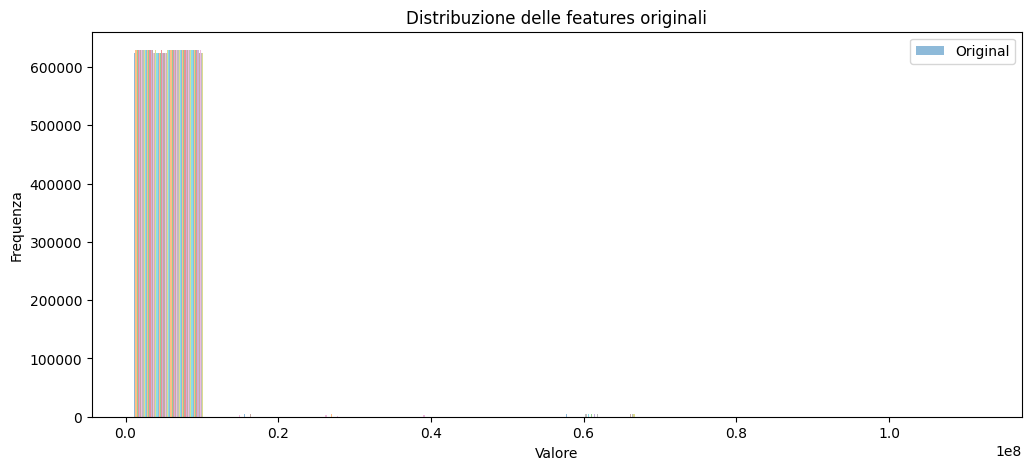

In [192]:
# Grafico dell'istogramma delle features originali
plt.figure(figsize=(12, 5))
plt.hist(X_train_num, bins=10, alpha=0.5, label='Original')
plt.title('Distribuzione delle features originali')
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.legend()
plt.show()

Ora applico la standardizzazione:

In [193]:
min_max_scaler = MinMaxScaler()
X_train_encoded[num_features] = min_max_scaler.fit_transform(X_train_encoded[num_features])

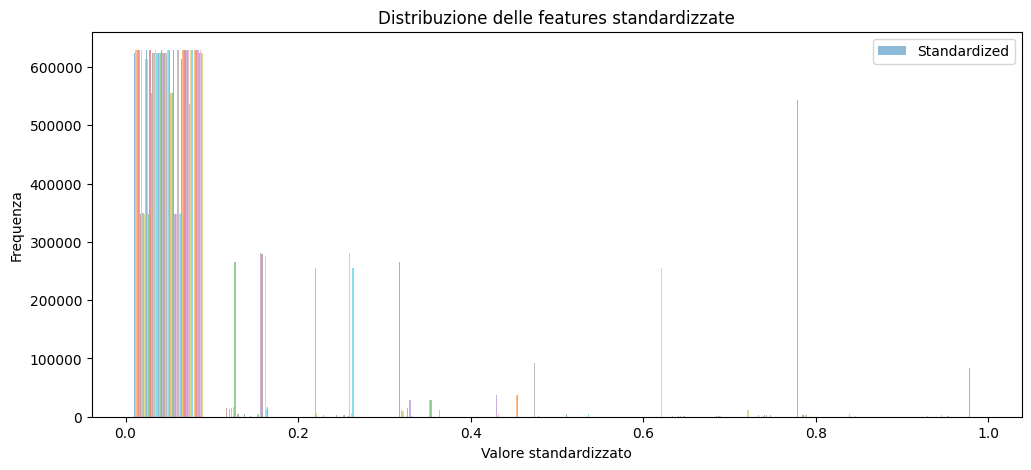

In [194]:
# Grafico dell'istogramma delle features standardizzate
plt.figure(figsize=(12, 5))
plt.hist(X_train_encoded[num_features], bins=10, alpha=0.5, label='Standardized')
plt.title('Distribuzione delle features standardizzate')
plt.xlabel('Valore standardizzato')
plt.ylabel('Frequenza')
plt.legend()
plt.show()

# FEATURE SELECTION

Mediante eliminazione ricorsiva delle feature, utilizzando una random forest come classificatore, si ottiene questo sottoinsieme di 44 feature più significative:

In [195]:
selected_features = [
    'Flow Duration',
    'Tot Fwd Pkts',
    'Tot Bwd Pkts',
    'TotLen Bwd Pkts',
    'Fwd Pkt Len Max',
    'Fwd Pkt Len Std',
    'Bwd Pkt Len Max',
    'Bwd Pkt Len Mean',
    'Flow IAT Mean',
    'Flow IAT Std',
    'Flow IAT Max',
    'Fwd IAT Tot',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Fwd IAT Max',
    'Bwd IAT Tot',
    'Bwd IAT Mean',
    'Bwd IAT Max',
    'Fwd Header Len',
    'Bwd Header Len',
    'Fwd Pkts/s',
    'Bwd Pkts/s',
    'Pkt Len Max',
    'Pkt Len Std',
    'Pkt Size Avg',
    'Bwd Seg Size Avg',
    'Subflow Fwd Pkts',
    'Subflow Bwd Pkts',
    'Subflow Bwd Byts',
    'Fwd Seg Size Min',
    'Active Min',
    'Idle Mean',
    'Idle Max',
    'Idle Min',
    'Dst Port_22',
    'Dst Port_80',
    'Dst Port_Other',
    'Fwd PSH Flags_1',
    'FIN Flag Cnt_1',
    'SYN Flag Cnt_1',
    'PSH Flag Cnt_0',
    'PSH Flag Cnt_1',
    'ACK Flag Cnt_1',
    'ECE Flag Cnt_0'
]

In [196]:
len(selected_features)

44

In [197]:
# Creo un nuovo DataFrame df che contiene solo le colonne specificate (allo stesso tempo quindi droppo la feature dei target)
X_train_encoded = X_train_encoded[selected_features]

# TRANSFORMATION PIPELINE 

Definisco una funzione che ripercorre le trasformazioni applicate al set di addestramento, in modo da effettuare la stessa pipeline di pre-processamento anche al set di test e di validazione:

In [198]:
def preprocess_data(set):

    # Applico la funzione alla colonna 'Dst Port' del DataFrame
    set['Dst Port'] = set['Dst Port'].apply(trasforma_dst_port)

    # Rimuovo le colonne che contengono un unico valore ripetuto
    set = set.drop('Bwd PSH Flags', axis=1)
    set = set.drop('Fwd URG Flags', axis=1)
    set = set.drop('Bwd URG Flags', axis=1)
    set = set.drop('CWE Flag Count', axis=1)
    set = set.drop('Fwd Blk Rate Avg', axis=1)
    set = set.drop('Bwd Blk Rate Avg', axis=1)
    set = set.drop('Bwd Pkts/b Avg', axis=1)
    set = set.drop('Bwd Byts/b Avg', axis=1)

    # Setto il tipo delle numeriche a float (in modo che siano uniformi)
    set[num_features] = set[num_features].astype(float)

    # Inizializzo un DataFrame vuoto per concatenare i risultati
    encoded_features_preprocess = pd.DataFrame(index=set.index)

    # Applico la trasformazione ad ogni feature categorica 
    encoded_features_preprocess = cat_encoder.transform(set[cat_features])

    # Droppo le vecchie feature categoriche
    set_dropped = set.drop(columns=cat_features)

    # Concateno il vecchio DataFrame senza le feature categoriche con il nuovo DataFrame encodato
    set_encoded = pd.concat([set_dropped, encoded_features_preprocess], axis=1)

    # Applico la standardizzazione
    set_encoded[num_features] = min_max_scaler.transform(set_encoded[num_features])

    # Creo un nuovo DataFrame df che contiene solo le colonne specificate (allo stesso tempo quindi droppo la feature dei target)
    set_encoded = set_encoded[selected_features]

    return set_encoded

In [199]:
# Applico la funzione di preprocessing sia al test set che al validation set
train_set_processed = X_train_encoded
val_set_processed = preprocess_data(X_val)
test_set_processed = preprocess_data(X_test)

# CHECKING LABEL DISTRIBUTION

Controllo che i target siano ben distribuiti fra tutti i set:

In [200]:
# Calcolo la percentuale di istanze benigne e maligne per ogni set
def print_percentage(labels, label_encoder):

    # Decodifico le etichette
    decoded_labels = label_encoder.inverse_transform(np.argmax(labels, axis=1))
    
    # Calcolo le percentuali
    unique, counts = np.unique(decoded_labels, return_counts=True)
    total_instances = len(decoded_labels)
    percentages = {category: (count / total_instances) * 100 for category, count in zip(unique, counts)}
    
    # Stamp le percentuali
    for category, percentage in percentages.items():
        print(f"{category}: {percentage:.2f}%")
    print("---------------")

# Stampo le percentuali per ogni set
print("Training set:\n")
print_percentage(y_train_categorical, tts_encoder)

print("Validation set:\n")
print_percentage(y_val_categorical, tts_encoder)

print("Test set:\n")
print_percentage(y_test_categorical, tts_encoder)


Training set:

Benign: 42.61%
DoS attacks-Hulk: 44.06%
DoS attacks-SlowHTTPTest: 13.33%
---------------
Validation set:

Benign: 42.59%
DoS attacks-Hulk: 44.07%
DoS attacks-SlowHTTPTest: 13.35%
---------------
Test set:

Benign: 42.62%
DoS attacks-Hulk: 44.02%
DoS attacks-SlowHTTPTest: 13.36%
---------------


La distribuzione sembra ben bilanciata, posso procedere.

# SELECT AND TRAIN A MODEL

Definisco il modello che userò per addestrare la LSTM:

In [201]:
import tensorflow as tf

tf.random.set_seed(42)

def build_model(input_shape):

    # LSTM model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(len(tts_encoder.classes_), activation='softmax')  
    ])

    model.compile(loss='categorical_crossentropy',      # categorical perchè le etichette sono one-hot
              optimizer='adam',
              metrics=['accuracy'])

    return model

## TRAIN_TEST_SPLIT

Quando configuro la input_shape nel modello, occorre specificare solo le dimensioni (timesteps, features) perché batch_size viene gestito automaticamente durante l'addestramento. 
Essendo i dati inizialmente in formato 2D (ogni riga rappresenta un campione con 44 feature), la loro forma è (batch_size, 44). 

Tuttavia, le LSTM richiedono dati di input in formato 3D con la forma (batch_size, timesteps, features), dunque occorre espandere la dimensione dei dati per far sì che ogni campione abbia una dimensione temporale esplicita.

In [202]:
# Aggiungo una dimensione ai dati di input per soddisfare la forma attesa dall'LSTM (batch_size, timesteps, feature per timestep)
X_train_reshaped = np.expand_dims(train_set_processed, axis=1)
X_val_reshaped = np.expand_dims(val_set_processed, axis=1)
X_test_reshaped = np.expand_dims(test_set_processed, axis=1)

### SELECT THE TIMESTEPS VALUE

Analizzo la dimensione del dataset completo per decidere il valore da assegnare al parametro _timesteps_:

In [203]:
df.shape[0]

1048574

Di seguito provo vari valori per capire quale finestra temporale sia la più adatta al modello. Proseguirò in termini di numero di campioni (osservazioni), invece che in termini temporali.

#### MODEL 1 (timesteps = 24.000)

In [204]:
input_shape_24000 = (24000, len(selected_features)) 

model_24000 = build_model(input_shape_24000)

In [205]:
# Definisco una callbacks early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

# Addestro il modello usando i dati preprocessati
history = model_24000.fit(X_train_reshaped, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val_categorical), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_24000.evaluate(X_val_reshaped, y_val_categorical)
print(f'Validation Accuracy: {valid_acc * 100:.2f}%')

Epoch 1/5


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.4737 - loss: 0.8683 - val_accuracy: 0.4841 - val_loss: 0.8408
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4802 - loss: 0.8398 - val_accuracy: 0.4836 - val_loss: 0.8358
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.4811 - loss: 0.8356 - val_accuracy: 0.4838 - val_loss: 0.8303
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4823 - loss: 0.8316 - val_accuracy: 0.4839 - val_loss: 0.8245
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 815us/step - accuracy: 0.4836 - loss: 0.8407
Validation Accuracy: 48.41%


In [206]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_24000.evaluate(X_test_reshaped, y_test_categorical)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

 180/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 846us/step - accuracy: 0.4989 - loss: 0.8301

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 797us/step - accuracy: 0.4850 - loss: 0.8402
Test Accuracy: 48.44%


#### MODEL 2 (timesteps = 1456)

Scelgo di utilizzare una finestra temporale di 1 minuto, in modo da cogliere eventuali pattern significativi che andrebbero persi con finestre più ampie. Il numero di osservazioni che costituiscono il dataset è di 1048574, lo divido per il numero di minuti totali trascorsi a effettuare le osservazioni (12 ore = 720 min) e ottengo il mio valore di timesteps = 1456 

In [207]:
input_shape_1400 = (1456, len(selected_features)) 

model_1400 = build_model(input_shape_1400)

In [208]:
# Definisco una callbacks early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

# Addestro il modello usando i dati preprocessati
history = model_1400.fit(X_train_reshaped, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val_categorical), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_1400.evaluate(X_val_reshaped, y_val_categorical)
print(f'Validation Accuracy: {valid_acc * 100:.2f}%')

Epoch 1/5


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.4732 - loss: 0.8685 - val_accuracy: 0.4840 - val_loss: 0.8407
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4807 - loss: 0.8396 - val_accuracy: 0.4839 - val_loss: 0.8353
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4812 - loss: 0.8359 - val_accuracy: 0.4843 - val_loss: 0.8322
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4827 - loss: 0.8331 - val_accuracy: 0.4825 - val_loss: 0.8273
Epoch 5/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4826 - loss: 0.8304 - val_accuracy: 0.4850 - val_loss: 0.8288
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 821us/step - accuracy: 0.4841 - loss: 0.8290
Validation Accuracy: 48.50%


In [209]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_1400.evaluate(X_test_reshaped, y_test_categorical)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

 244/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 829us/step - accuracy: 0.4914 - loss: 0.8221

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 821us/step - accuracy: 0.4853 - loss: 0.8282
Test Accuracy: 48.58%


#### MODEL 3 (timesteps = 500)

In [210]:
input_shape_500 = (500, len(selected_features)) 

model_500 = build_model(input_shape_500)

In [211]:
# Definisco una callbacks early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Addestro il modello usando i dati preprocessati
history = model_500.fit(X_train_reshaped, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val_categorical), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_500.evaluate(X_val_reshaped, y_val_categorical)
print(f'Validation Accuracy: {valid_acc * 100:.2f}%')

Epoch 1/5


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.4734 - loss: 0.8676 - val_accuracy: 0.4841 - val_loss: 0.8413
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4802 - loss: 0.8398 - val_accuracy: 0.4836 - val_loss: 0.8355
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4813 - loss: 0.8360 - val_accuracy: 0.4841 - val_loss: 0.8320
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4826 - loss: 0.8330 - val_accuracy: 0.4848 - val_loss: 0.8266
Epoch 5/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4821 - loss: 0.8300 - val_accuracy: 0.4862 - val_loss: 0.8251
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 815us/step - accuracy: 0.4859 - loss: 0.8252
Validation Accuracy: 48.62%


In [212]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_500.evaluate(X_test_reshaped, y_test_categorical)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

 324/6554 ━━━━━━━━━━━━━━━━━━━━ 4s 781us/step - accuracy: 0.4989 - loss: 0.8193

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 799us/step - accuracy: 0.4879 - loss: 0.8245
Test Accuracy: 48.75%


#### MODEL 4 (timesteps = 250)

In [213]:
input_shape_250 = (250, len(selected_features)) 

model_250 = build_model(input_shape_250)

In [214]:
# Definisco una callbacks early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Addestro il modello usando i dati preprocessati
history = model_250.fit(X_train_reshaped, y_train_categorical, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val_categorical), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_250.evaluate(X_val_reshaped, y_val_categorical)
print(f'Validation Accuracy: {valid_acc * 100:.2f}%')

Epoch 1/5


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.4736 - loss: 0.8683 - val_accuracy: 0.4841 - val_loss: 0.8410
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4799 - loss: 0.8397 - val_accuracy: 0.4835 - val_loss: 0.8355
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4809 - loss: 0.8357 - val_accuracy: 0.4840 - val_loss: 0.8318
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4818 - loss: 0.8326 - val_accuracy: 0.4839 - val_loss: 0.8261
Epoch 5/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.4819 - loss: 0.8297 - val_accuracy: 0.4855 - val_loss: 0.8233
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 788us/step - accuracy: 0.4849 - loss: 0.8233
Validation Accuracy: 48.55%


In [215]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_250.evaluate(X_test_reshaped, y_test_categorical)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

 128/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 798us/step - accuracy: 0.4947 - loss: 0.8167

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 792us/step - accuracy: 0.4859 - loss: 0.8227
Test Accuracy: 48.61%
